<a href="https://colab.research.google.com/github/Gratisfo/project_ml/blob/main/%D0%AD%D0%BC%D0%B1%D0%B5%D0%B4%D0%B4%D0%B8%D0%BD%D0%B3%D0%B8_%2B_%D1%81%D0%B5%D1%82%D0%B8_%D0%BD%D0%B0_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Эмбеддинги + сети на keras**

Построение нейронной сети на Keras для задачи классификации твитов. Посмотреть и скачать корпус можно из источника http://study.mokoron.com, (либо сразу по прямым ссылкам в ноутбуке)

In [ ]:
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv 

--2021-02-12 18:25:16--  https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r6u59ljhhjdg6j0/negative.csv [following]
--2021-02-12 18:25:16--  https://www.dropbox.com/s/raw/r6u59ljhhjdg6j0/negative.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4a7e6ce94338f936067fd1b95f.dl.dropboxusercontent.com/cd/0/inline/BI1tHO9rqfTfweGfybKbMoMW2cpcVZBmneFtC4Yj0RZgoU-iFcZI3QC5gewy73ZesU6ZPSKiT4UpSZR155ZZcDxuNUhofFf5lknrdK9zC3-SOg/file# [following]
--2021-02-12 18:25:16--  https://uc4a7e6ce94338f936067fd1b95f.dl.dropboxusercontent.com/cd/0/inline/BI1tHO9rqfTfweGfybKbMoMW2cpcVZBmneFtC4Yj0RZgoU-iFcZI3QC5gewy73ZesU6ZPSKiT4UpSZR155ZZcDxuNUhofFf5lknrdK9zC3-SOg/file
Resolving uc4

Решите задачу, используя две следующие архитектуры, для каждой посчитайте accuracy, precision, recall *:

1. модель берет слова, пропускает их через Embedding слой. По эмбеддингам проходит biLSTM, на выходе линейный слой и выходной слой.

*   Embedding слой обучается внутри модели -- 1 балл

*   подгружаются обученные эмбеддинги для русского языка** -- 1 балл

*   fasttext эмбеддинги обучаются на всем корпусе с нуля*** -- 2 балла




In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, Bidirectional, TimeDistributed, InputLayer
from tensorflow.keras.layers import Embedding, Conv1D, Input, concatenate, SpatialDropout1D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from keras.utils.vis_utils import plot_model
import tensorflow as tf
import nltk
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
!pip install razdel

In [ ]:
!pip install pymorphy2[fast]

In [ ]:
import pandas as pd

# – id: уникальный номер сообщения в системе twitter;
# – tdate: дата публикации сообщения (твита);
# – tmane: имя пользователя, опубликовавшего сообщение;
# – ttext:  текст сообщения (твита);
# – ttype: поле в котором в дальнейшем будет указано к кому классу относится твит (положительный, отрицательный, нейтральный);
# – trep: количество реплаев к данному сообщению. В настоящий момент API твиттера не отдает эту информацию;
# – trtw: количество ретвитов (количество копирований этого сообщения другими пользователями);
# – tfav: число сколько раз данное сообщение было добавлено в избранное другими пользователями;
# – tstcount: число всех сообщений пользователя в сети twitter;
# – tfol: количество фоловеров пользователя (тех людей, которые читают пользователя);
# – tfrien: количество друзей пользователя (те люди, которых читает пользователь);
# – listcount: количество листов-подписок в которые добавлен твиттер-пользователь.

col =['id', 'tdate', 'tname', 'ttext', 'ttype', 'trep', 'trtw','tfav', 'tstcount', 'tfol', 'tfrien', 'listcount']
pos = pd.read_csv('positive.csv', sep=';')
neg = pd.read_csv('negative.csv', sep=';')
neg.columns = col
pos.columns = col
pos['ttype'] = pos['ttype'].apply(lambda x: 1)
neg['ttype'] = neg['ttype'].apply(lambda x: 0)

In [ ]:
# препроцессинг
import re
import pymorphy2

import nltk
import string
from nltk.corpus import stopwords
from razdel import tokenize

nltk.download('stopwords')
morph = pymorphy2.MorphAnalyzer()

def preproc_text(text):
    # токенизируем
    tokens = [_.text for _ in list(tokenize(text))]
   
    # приводим к нижнему регистру
    tokens = [w.lower() for w in tokens]
    
    # убираем пунктуацию
    # оставим знаки, которые используются для смайликов : ( ) = /
    punct = [ '@', '.', ',', '[', ']', "'", '«', '»', '-',
          '_', '%', '^', '&', '*', "+", "=", '{', '}',
          '?', '!', '—', '--', '<', '>',
          '"',  "§", '№', '“', 'http', '#']
    words = [w for w in tokens  if w not in punct]

    # приводим к начальной форме
    words = [morph.parse(w)[0].normal_form for w in words]
    stop_words = set(stopwords.words('russian'))   
    words = [w for w in words if not w in stop_words]
    return words

# пробовала делать это тоже, но аккураси падает
# убираем числа и оставлем только кирилицу
# words = [word for word in stripped if word.isalpha()]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# создадим новый df
data = pd.concat([neg, pos])

# перемешаем данные
from sklearn.utils import shuffle 
data = shuffle(data).reset_index(drop=True)

In [ ]:
# запустить чтобы сделать тестовый дф
data = data[:20000]

### Подготовка данных

In [ ]:
data

,id,tdate,tname,ttext,ttype,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
0,409607333606871040,1386492973,owycucozef,"""Аллоды Онлайн"" пошли в печать. Пора собирать ...",1,0,0,0,175,102,102,0
1,409629751855554561,1386498318,Lenoocs,@nemnogo_ulibki ну бывает и такое)) сериал при...,1,0,0,0,2019,61,35,0
2,410342310480592896,1386668205,Nancy_Muser_,@from___6277 аахаха мы тоже всегда плохо по ма...,1,0,0,0,6088,158,281,0
3,411175204845400064,1386866782,kolesnikate,"как же я хочу увидеть тебя,соскучилась так :(",0,0,0,0,3711,49,23,1
4,409068879571595264,1386364595,Natalia_1405,Тем временем у Фани в голове: сессия скоро... ...,1,0,0,0,3384,48,25,0
...,...,...,...,...,...,...,...,...,...,...,...,...
226827,408919973097402368,1386329093,Lerka04,"@robinwitaker нет.\nКак же твои девочки,без та...",1,0,0,0,194,7,11,0
226828,411367330807963648,1386912589,alise_abyss,Я еще морально не готова Т_Т((((( #прощайстепуха,0,0,0,0,295,46,29,0
226829,409618198565490689,1386495563,Corean_11,"Япошки жжут :-D ""@4pdaru: #Honda представила ...",1,0,0,0,283,18,59,1
226830,409357563097272320,1386433423,kyzmi47,@DizzyShake но ты отказалась увидеться((( это ...,0,0,0,0,2281,61,100,0


In [ ]:
#препроцессим
data['clean_text'] = data['ttext'].apply(lambda x: preproc_text(x))
data['len_text'] = data['clean_text'].apply(lambda x: len(x))
max_text_len = data.len_text.max()

In [ ]:
tags = []
for l, t in zip(data['len_text'], data['ttype']):
  tag = [t] * l
  tags.append(tag)

In [ ]:
# разделим выборку на тест\трейн
text_train, text_test, tag_train, tag_test = train_test_split(list(data['clean_text']), 
                                                                  tags, 
                                                                  test_size=0.2, 
                                                                  random_state=1)

In [ ]:
# создадим словарь слов на уровне трейна
vocab = Counter()
for sent in text_train:
    sent = [word for word in sent]
    vocab.update(sent)

In [ ]:
# выкинем редкие слова
filtered_vocab = {word for word in vocab if vocab[word] > 50}
len(filtered_vocab)

3320

In [ ]:
# присвоим id каждому слову в словаре
word2id = {word:i + 2 for i,word in enumerate(filtered_vocab)}
word2id['pad'] = 0
word2id['unk'] = 1  

id2word = {i:word for word, i in word2id.items()}

In [ ]:
len(id2word)

3322

In [ ]:
tag2id = {'pad':0, 'unk':1}  
for taggs in tag_train:
    for tag in taggs:
      if tag not in tag2id:
        tag2id[tag] = len(tag2id)

id2tag = {i:tag for tag, i in tag2id.items()}

In [ ]:
id2tag

{0: 'pad', 1: 'unk', 2: 1, 3: 0}

In [ ]:
def data2ints(data, smth2id):
  int_data = []
  for seq in data:
      int_seq = []
      for i in seq:
        int_seq.append(smth2id.get(i, 1))
  
      int_data.append(int_seq)
  return int_data


In [ ]:
X_train_ids, X_test_ids = data2ints(text_train, word2id), data2ints(text_test, word2id)
y_train_ids, y_test_ids = data2ints(tag_train, tag2id), data2ints(tag_test, tag2id)


print(X_train_ids[0])
print(y_train_ids[0])

print(X_test_ids[0])
print(y_test_ids[0])

[1449, 1, 1873, 2946, 1, 272, 1, 1, 1526, 1, 176, 2445]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[1, 2775, 218, 966, 618, 1743]
[3, 3, 3, 3, 3, 3]


In [ ]:
X_train, X_test = pad_sequences(X_train_ids, maxlen=max_text_len, padding='post'), pad_sequences(X_test_ids, maxlen=max_text_len, padding='post')
y_train, y_test = pad_sequences(y_train_ids, maxlen=max_text_len, padding='post'), pad_sequences(y_test_ids, maxlen=max_text_len, padding='post')

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(181465, 130) (181465, 130) (45367, 130) (45367, 130)


In [ ]:
# посмотрим что там по тегам
print(text_train[5])
print(X_train_ids[5][0])
print(X_train[5])
print([id2word[i] for i in X_train[5]][:50])


['это', 'хороший', 'предпрофильный', 'подготовка', ')', 'денисов', 'заборовский', 'обожать', 'lt', ';', '3']
2704
[2704  989    1 1534 1714    1    1  405 2187 2692 1897    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
['это', 'хороший', 'unk', 'подготовка', ')', 'unk', 'unk', 'обожать', 'lt', ';', '3', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad',

In [ ]:
y_train, y_test = to_categorical(y_train, num_classes=len(tag2id)), to_categorical(y_test, num_classes=len(tag2id))

### Модель с внутренними эмбеддингами

In [ ]:
from tensorflow.keras import metrics
word_in = Input(shape=(max_text_len))
emb_word = Embedding(input_dim=len(word2id), output_dim=300, mask_zero=True)(word_in)
lstm = Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.2))(emb_word)
out = TimeDistributed(Dense(len(tag2id), activation="softmax"))(lstm)

model = Model(inputs= word_in, outputs=out)
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics = [metrics.Precision(), metrics.Recall(), metrics.Accuracy()])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 130)]             0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 130, 300)          996900    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 130, 256)          439296    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 130, 4)            1028      
Total params: 1,437,224
Trainable params: 1,437,224
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
X_train.shape

(181465, 130)

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=5, verbose=1)

Epoch 1/5
1418/1418 [==============================] - 3203s 2s/step - loss: 0.0114 - precision_4: 0.9688 - recall_4: 0.9257 - accuracy: 0.0069 - val_loss: 0.0013 - val_precision_4: 0.9940 - val_recall_4: 0.9939 - val_accuracy: 0.0216
Epoch 2/5
1418/1418 [==============================] - 3208s 2s/step - loss: 8.0907e-04 - precision_4: 0.9965 - recall_4: 0.9965 - accuracy: 0.0282 - val_loss: 0.0013 - val_precision_4: 0.9947 - val_recall_4: 0.9947 - val_accuracy: 0.0322
Epoch 3/5
1418/1418 [==============================] - 3216s 2s/step - loss: 6.2201e-04 - precision_4: 0.9975 - recall_4: 0.9975 - accuracy: 0.0355 - val_loss: 0.0014 - val_precision_4: 0.9949 - val_recall_4: 0.9949 - val_accuracy: 0.0459
Epoch 4/5
1418/1418 [==============================] - 3354s 2s/step - loss: 4.2654e-04 - precision_4: 0.9984 - recall_4: 0.9984 - accuracy: 0.0491 - val_loss: 0.0016 - val_precision_4: 0.9943 - val_recall_4: 0.9942 - val_accuracy: 0.0496
Epoch 5/5
1418/1418 [===========================

Делала так мало эпох, потому что каждая эпоха заняла грузилась по 50 минут


### Модель с подгружеными эмбеддингами для русского языка

In [ ]:
# скачаем готовые эмбеддинги для русского с RusVectores
!wget -c https://rusvectores.org/static/models/rusvectores4/fasttext/araneum_none_fasttextcbow_300_5_2018.tgz

--2021-02-11 16:17:54--  https://rusvectores.org/static/models/rusvectores4/fasttext/araneum_none_fasttextcbow_300_5_2018.tgz
Resolving rusvectores.org (rusvectores.org)... 116.203.104.23
Connecting to rusvectores.org (rusvectores.org)|116.203.104.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2691248108 (2.5G) [application/x-gzip]
Saving to: ‘araneum_none_fasttextcbow_300_5_2018.tgz’

araneum_none_fastte 100%[===================>]   2.51G  28.7MB/s    in 93s     

2021-02-11 16:19:28 (27.6 MB/s) - ‘araneum_none_fasttextcbow_300_5_2018.tgz’ saved [2691248108/2691248108]



In [ ]:
!tar -xzf araneum_none_fasttextcbow_300_5_2018.tgz

In [ ]:
! pip install --upgrade gensim

In [ ]:
from gensim.models import Word2Vec, KeyedVectors
model_file = 'araneum_none_fasttextcbow_300_5_2018.model'
model = KeyedVectors.load(model_file)

In [ ]:
weights = []
for k, v in id2word.items():
  # print(k, v)
    if v in model:
        weights.append(model[v])

weights = np.array(weights)
weights

array([[-3.16109392e-04, -2.35537402e-04, -1.16418596e-04, ...,
        -3.34479933e-04, -8.25069437e-05,  1.67314836e-04],
       [-8.51661637e-02, -3.73549834e-02,  1.71685368e-01, ...,
         4.43141721e-02,  9.02225673e-02, -2.37400942e-02],
       [-1.48450211e-02, -1.17211230e-02,  2.83239614e-02, ...,
         8.52834061e-02,  5.33331260e-02, -8.95986110e-02],
       ...,
       [-7.36962110e-02, -2.85307616e-02,  3.51197814e-04, ...,
         7.92091414e-02, -7.44513273e-02,  1.31614720e-02],
       [ 2.59977654e-02, -6.86561093e-02,  4.13467064e-02, ...,
         6.94484785e-02,  6.46858767e-04, -1.27136454e-01],
       [-6.12223707e-02, -7.02598765e-02,  1.70590598e-02, ...,
         5.85961994e-03, -5.62684089e-02, -2.78596189e-02]], dtype=float32)

In [ ]:
X_train, X_test = pad_sequences(X_train_ids, maxlen=max_text_len, padding='post'), pad_sequences(X_test_ids, maxlen=max_text_len, padding='post')
y_train, y_test = pad_sequences(y_train_ids, maxlen=max_text_len, padding='post'), pad_sequences(y_test_ids, maxlen=max_text_len, padding='post')

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(181465, 130) (181465, 130) (45367, 130) (45367, 130)


In [ ]:
y_train, y_test = to_categorical(y_train, num_classes=len(tag2id)), to_categorical(y_test, num_classes=len(tag2id))

In [ ]:
# подгружаются обученные эмбеддинги для русского языка
word_in = Input(shape=(max_text_len))
emb_word = Embedding(input_dim=len(word2id), output_dim=weights.shape[1], 
                          trainable=False, weights=[weights])(word_in)
lstm = Bidirectional(LSTM(units=128, return_sequences=True,recurrent_dropout=0.2))(emb_word)
out = TimeDistributed(Dense(len(tag2id), activation="softmax"))(lstm)


model2 = Model(inputs= word_in, outputs=out)
optimizer = optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics = [metrics.Precision(), metrics.Recall(), metrics.Accuracy()])
model2.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 130)]             0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 130, 300)          996900    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 130, 256)          439296    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 130, 4)            1028      
Total params: 1,437,224
Trainable params: 440,324
Non-trainable params: 996,900
_________________________________________________________________


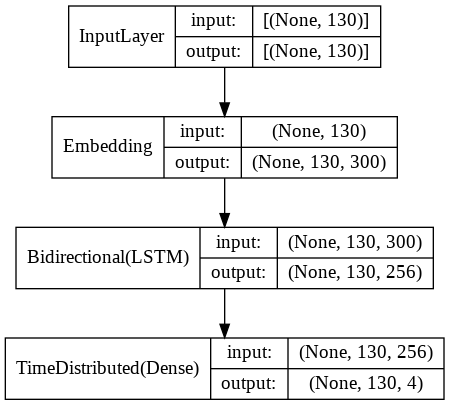

In [ ]:
plot_model(model2, show_shapes=True, show_layer_names=False)

In [ ]:
model2.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=5, verbose=1)

Epoch 1/5
1418/1418 [==============================] - 2610s 2s/step - loss: 0.0869 - precision_5: 0.9844 - recall_5: 0.9436 - accuracy: 8.6372e-04 - val_loss: 0.0082 - val_precision_5: 0.9971 - val_recall_5: 0.9969 - val_accuracy: 0.0636
Epoch 2/5
1418/1418 [==============================] - 2602s 2s/step - loss: 0.0076 - precision_5: 0.9972 - recall_5: 0.9971 - accuracy: 0.1312 - val_loss: 0.0053 - val_precision_5: 0.9980 - val_recall_5: 0.9979 - val_accuracy: 0.1959
Epoch 3/5
1418/1418 [==============================] - 2592s 2s/step - loss: 0.0051 - precision_5: 0.9980 - recall_5: 0.9980 - accuracy: 0.1676 - val_loss: 0.0045 - val_precision_5: 0.9983 - val_recall_5: 0.9982 - val_accuracy: 0.0262
Epoch 4/5
1418/1418 [==============================] - 2590s 2s/step - loss: 0.0041 - precision_5: 0.9984 - recall_5: 0.9984 - accuracy: 0.0643 - val_loss: 0.0036 - val_precision_5: 0.9986 - val_recall_5: 0.9986 - val_accuracy: 0.2106
Epoch 5/5
1418/1418 [==============================] - 2

Accaracy все еще очень мала, но когда я запускала модель заданными метриками только `metrics = ['acc']` начиная со второй-третей эпохи аккураси была такой (к сожалению скрина 3-й эпохи не соранилось, но это я честно говорю и не вру! 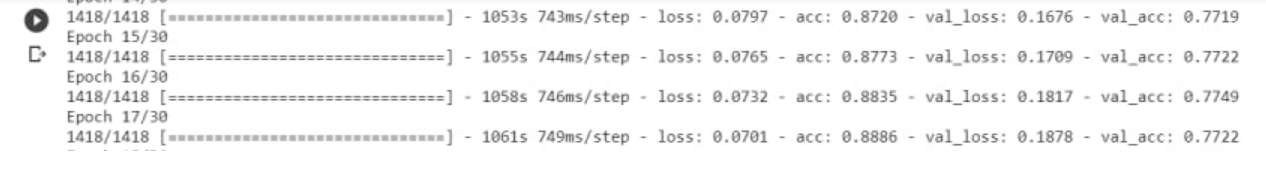

Так что мне кажется возьможно это как то связано с метриками, но я не совсем понимаю как


### Модель с обучающимися эмбеддингами для русского языка

In [ ]:
# fasttext эмбеддинги обучаются на всем корпусе с нуля
from gensim import models
ft = models.FastText(size=100)
ft.build_vocab(sentences=data['clean_text'][:20000]) # пока пробуем на маленьких данных
ft.train(sentences=data['clean_text'], total_examples=len(data['clean_text']), epochs=10)

In [ ]:
weights_ft = []
for k, v in id2word.items():
    if v in ft:
        weights_ft.append(ft.wv[v])

weights_ft = np.array(weights_ft)

In [ ]:
from tensorflow.keras import metrics 
word_in = Input(shape=(max_text_len))
emb_word = Embedding(input_dim=len(word2id), output_dim=weights_ft.shape[1], 
                          trainable=False, weights=[weights_ft])(word_in)
lstm = Bidirectional(LSTM(units=128, return_sequences=True,recurrent_dropout=0.2))(emb_word)
out = TimeDistributed(Dense(len(tag2id), activation="softmax"))(lstm)


model3_ = Model(inputs=word_in, outputs=out)
optimizer = optimizers.Adam(learning_rate=0.001)
model3_.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics = [metrics.Precision(), metrics.Recall(), metrics.Accuracy()])
model3_.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 92)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 92, 100)           37500     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 92, 256)           234496    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 92, 4)             1028      
Total params: 273,024
Trainable params: 235,524
Non-trainable params: 37,500
_________________________________________________________________


In [ ]:
model3_.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=5, verbose=1)

Epoch 1/5
125/125 [==============================] - 110s 852ms/step - loss: 0.2614 - precision_1: 0.9395 - recall_1: 0.8359 - accuracy: 0.0000e+00 - val_loss: 0.0696 - val_precision_1: 0.9715 - val_recall_1: 0.9665 - val_accuracy: 0.0000e+00
Epoch 2/5
125/125 [==============================] - 104s 836ms/step - loss: 0.0587 - precision_1: 0.9769 - recall_1: 0.9734 - accuracy: 0.0000e+00 - val_loss: 0.0439 - val_precision_1: 0.9819 - val_recall_1: 0.9807 - val_accuracy: 0.0000e+00
Epoch 3/5
125/125 [==============================] - 105s 844ms/step - loss: 0.0428 - precision_1: 0.9830 - recall_1: 0.9815 - accuracy: 0.0000e+00 - val_loss: 0.0322 - val_precision_1: 0.9878 - val_recall_1: 0.9871 - val_accuracy: 0.0000e+00
Epoch 4/5
125/125 [==============================] - 105s 839ms/step - loss: 0.0327 - precision_1: 0.9875 - recall_1: 0.9868 - accuracy: 0.0000e+00 - val_loss: 0.0253 - val_precision_1: 0.9907 - val_recall_1: 0.9901 - val_accuracy: 0.0000e+00
Epoch 5/5
125/125 [=========

In [ ]:
# попробуем поменять параметры модели и увеличить кол-во эпох обучения
ft = models.FastText(size=100, window=5, min_count=3, workers=5, sg=1)
ft.build_vocab(sentences=data['clean_text'][:20000])
ft.train(sentences=data['clean_text'][:20000], total_examples=len(data['clean_text'][:20000]), epochs=15)

weights_ft = []
for k, v in id2word.items():
    if v in ft:
        weights_ft.append(ft.wv[v])

weights_ft = np.array(weights_ft)

# чтобы это запустить, в начале нужно запустить ячейку с обрезанием датасета, потому что перепутаются все tag2id word2id
# здесь оно все тренируется на маленьком датасете, просто чтобы проверить параметры модели

word_in = Input(shape=(max_text_len))
emb_word = Embedding(input_dim=len(word2id), output_dim=weights_ft.shape[1], 
                          trainable=False, weights=[weights_ft])(word_in)
lstm = Bidirectional(LSTM(units=128, return_sequences=True,recurrent_dropout=0.2))(emb_word)
out = TimeDistributed(Dense(len(tag2id), activation="softmax"))(lstm)


model3_ = Model(inputs=word_in, outputs=out)
optimizer = optimizers.Adam(learning_rate=0.001)
model3_.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics = [metrics.Precision(), metrics.Recall(), metrics.Accuracy()])

model3_.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=5, verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  


Epoch 1/5
125/125 [==============================] - 133s 1s/step - loss: 0.2071 - precision_5: 0.9498 - recall_5: 0.8647 - accuracy: 0.0000e+00 - val_loss: 0.0360 - val_precision_5: 0.9878 - val_recall_5: 0.9856 - val_accuracy: 0.0000e+00
Epoch 2/5
125/125 [==============================] - 140s 1s/step - loss: 0.0333 - precision_5: 0.9878 - recall_5: 0.9861 - accuracy: 0.0000e+00 - val_loss: 0.0226 - val_precision_5: 0.9921 - val_recall_5: 0.9916 - val_accuracy: 0.0000e+00
Epoch 3/5
125/125 [==============================] - 130s 1s/step - loss: 0.0210 - precision_5: 0.9922 - recall_5: 0.9917 - accuracy: 0.0000e+00 - val_loss: 0.0172 - val_precision_5: 0.9937 - val_recall_5: 0.9934 - val_accuracy: 0.0000e+00
Epoch 4/5
125/125 [==============================] - 130s 1s/step - loss: 0.0165 - precision_5: 0.9938 - recall_5: 0.9935 - accuracy: 0.0000e+00 - val_loss: 0.0145 - val_precision_5: 0.9945 - val_recall_5: 0.9943 - val_accuracy: 0.0000e+00
Epoch 5/5
125/125 [=====================

Так как будто бы стало совсем немного лучше

Теперь запустим модель на полном датасете (Fasttext с выбранными параметрами)

In [ ]:
ft = models.FastText(size=100, window=5, min_count=3, workers=5, sg=1)
ft.build_vocab(sentences=data['clean_text'])
ft.train(sentences=data['clean_text'], total_examples=len(data['clean_text']), epochs=20)

weights_ft = []
for k, v in id2word.items():
    if v in ft:
        weights_ft.append(ft.wv[v])

weights_ft = np.array(weights_ft)

In [ ]:
word_in = Input(shape=(max_text_len))
emb_word = Embedding(input_dim=len(word2id), output_dim=weights_ft.shape[1], 
                          trainable=False, weights=[weights_ft])(word_in)
lstm = Bidirectional(LSTM(units=128, return_sequences=True,recurrent_dropout=0.2))(emb_word)
out = TimeDistributed(Dense(len(tag2id), activation="softmax"))(lstm)


model3 = Model(inputs=word_in, outputs=out)
optimizer = optimizers.Adam(learning_rate=0.001)
model3.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics = [metrics.Precision(), metrics.Recall(), metrics.Accuracy()])
model3.summary()

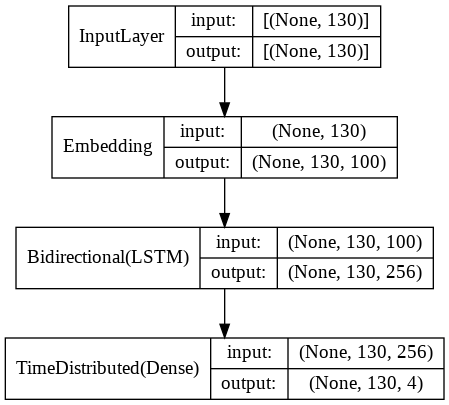

In [ ]:
plot_model(model3, show_shapes=True, show_layer_names=False)

In [ ]:
model3.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=5, verbose=1)

Epoch 1/5
1418/1418 [==============================] - 1711s 1s/step - loss: 0.0419 - precision: 0.9907 - recall: 0.9790 - accuracy: 2.0962e-08 - val_loss: 0.0045 - val_precision: 0.9982 - val_recall: 0.9982 - val_accuracy: 6.5280e-06
Epoch 2/5
1418/1418 [==============================] - 1707s 1s/step - loss: 0.0041 - precision: 0.9984 - recall: 0.9984 - accuracy: 0.0095 - val_loss: 0.0028 - val_precision: 0.9989 - val_recall: 0.9989 - val_accuracy: 0.0435
Epoch 3/5
1418/1418 [==============================] - 1708s 1s/step - loss: 0.0025 - precision: 0.9990 - recall: 0.9990 - accuracy: 0.0429 - val_loss: 0.0019 - val_precision: 0.9993 - val_recall: 0.9993 - val_accuracy: 0.1615
Epoch 4/5
1418/1418 [==============================] - 1710s 1s/step - loss: 0.0018 - precision: 0.9993 - recall: 0.9993 - accuracy: 0.1540 - val_loss: 0.0015 - val_precision: 0.9995 - val_recall: 0.9995 - val_accuracy: 0.1929
Epoch 5/5
1418/1418 [==============================] - 1712s 1s/step - loss: 0.0014 

In [ ]:
print('Accuracy for model_1: 0.0866')
print('Accuracy for model_2: 0.1714' )
print('Accuracy for model_3: 0.1863')

Accuracy for model_1: 0.0866
Accuracy for model_2: 0.1714
Accuracy for model_3: 0.1863


И так у нас получилось, что у последней модели где эмбеддинги обучались на наших текстах, мизерная аккураси оказалась самой большой, поэтому именно эту модель мы и будем использовать дальше

## Модель  с 2-мя входами

Усложним архитектуру. У этой модели два входа, один для эмбеддингов (выберете лучшие из предыдущего пункта), над ними biLSTM по всему предложению. Другой вход сети для символьного представления слов (идея с двумя входами показана в материале 12 недели). Каждое слово на втором входе пропускается через CharCNN. По полученным векторам на уровне предложения также проходит biLSTM. выходы обеих biLSTM конкатенируются, далее линейный слой, далее выходной слой. -- 3 балла

In [ ]:
chars = set([letter for word in filtered_vocab for letter in word])
n_chars = len(chars)
print(chars)

{'ь', 'j', 'ё', 't', 'з', 'б', '*', '?', 'u', ')', '|', 'ф', 'm', 'м', '4', 'c', 'o', 'g', 'с', '0', 'н', 'л', '_', '5', '=', 'д', '(', 'r', 'q', 'a', 'ы', 'l', 'о', 'т', '/', 'э', 'х', ':', '”', 'а', '7', 'щ', 'я', 'ч', '2', 'k', 'в', 'и', 'd', 'ц', 'у', '9', '!', 'й', 'ш', '1', ';', '…', 'v', 'г', 'p', 'ж', '6', 'р', 'е', 'i', 'п', '-', '8', 's', 'к', '.', 'ю', '3'}


In [ ]:
char2id = {c: i + 2 for i, c in enumerate(chars)}
char2id["pad"] = 0
char2id["unk"] = 1

id2char = {i:char for char, i in char2id.items()}

In [ ]:
char_max_len = max(len(x) for x in filtered_vocab)
print("максимальная длина слова:", char_max_len)

максимальная длина слова: 11


In [ ]:
def make_X_char(sentences):
  X_char = []
  for sentence in sentences:
      sent_seq = []
      for i in range(max_text_len):
          word_seq = []
          for j in range(char_max_len):
              try:
                  word_seq.append(char2id[sentence[i][j].lower()])
              except:
                  word_seq.append(char2id["pad"])
          sent_seq.append(word_seq)
      X_char.append(np.array(sent_seq))
  return np.array(X_char)

In [ ]:
X_char_train, X_char_test = make_X_char(text_train[:80000]), make_X_char(text_test[:16000])

In [ ]:
# один вход для слов
word_in = Input(shape=(max_text_len))
emb_word = Embedding(input_dim=len(word2id), output_dim=weights_ft.shape[1], 
                          trainable=False, weights=[weights_ft])(word_in)

# другой вход для символов
char_in = Input(shape=(max_text_len, char_max_len))
emb_char = TimeDistributed(Embedding(input_dim=len(char2id), output_dim=10, input_length=char_max_len))(char_in)

# свертка на символах (CharRNN) применяется к каждому слову отдельно
char_enc = TimeDistributed(Conv1D(filters=12, kernel_size=3))(emb_char)
char_flat = TimeDistributed(Flatten())(char_enc)

# LSTM проходится по всей последовательности, на каждом шаге беря эмбеддинг слова по словарю + символьный эмбеддинг слова 
x = concatenate([emb_word, char_flat])
main_lstm = Bidirectional(LSTM(units=128, return_sequences=True,
                               recurrent_dropout=0.2))(x)
out = TimeDistributed(Dense(len(tag2id), activation="softmax"))(main_lstm)

model_ = Model(inputs=[char_in, word_in], outputs=out)

from tensorflow.keras import metrics
optimizer = optimizers.Adam(learning_rate=0.001)
model_.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[metrics.Precision(), metrics.Recall(), metrics.Accuracy()])

In [ ]:
model_.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 130, 33)]    0                                            
__________________________________________________________________________________________________
time_distributed_4 (TimeDistrib (None, 130, 33, 10)  960         input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 130)]        0                                            
__________________________________________________________________________________________________
time_distributed_5 (TimeDistrib (None, 130, 31, 12)  372         time_distributed_4[0][0]         
____________________________________________________________________________________________

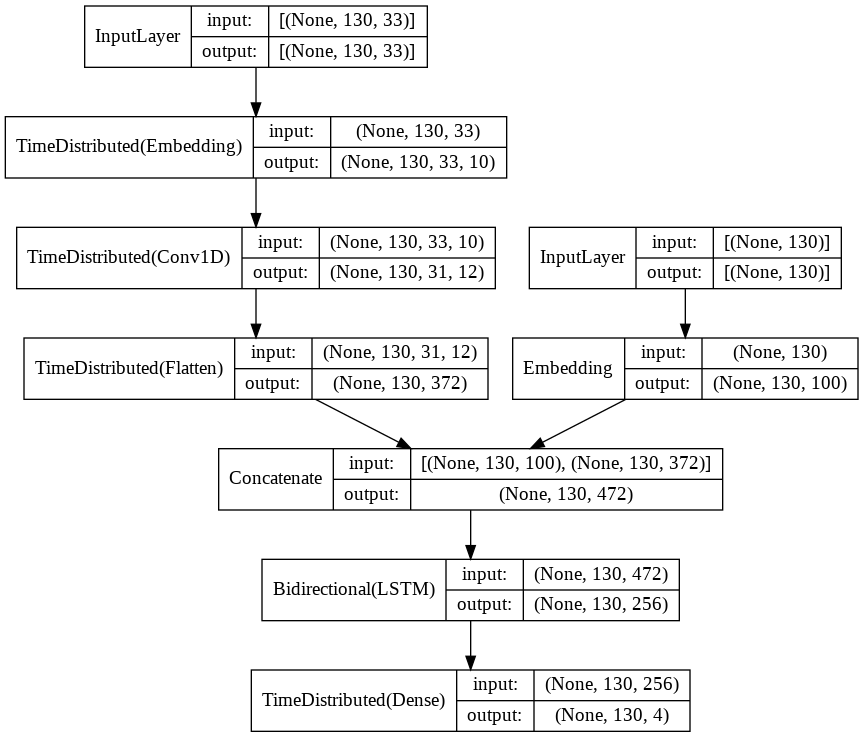

In [ ]:
plot_model(model_, show_shapes=True, show_layer_names=False)

У меня переполнялась ОЗУ три раза подряд, как бы я не пыталась это фиксить, поэтому пришлось сократить выборку в два раза.

In [ ]:
X_train = X_train[:80000]
y_train = y_train[:80000]
X_test = X_test[:16000]
y_test = y_test[:16000]

In [ ]:
model_.fit([X_char_train, X_train], y_train, validation_data=([X_char_test, X_test], y_test), batch_size=128, epochs=5, verbose=1)

Epoch 1/5
625/625 [==============================] - 1573s 3s/step - loss: 0.0016 - precision: 0.9994 - recall: 0.9994 - accuracy: 1.2019e-07 - val_loss: 0.0023 - val_precision: 0.9992 - val_recall: 0.9992 - val_accuracy: 0.0000e+00
Epoch 2/5
625/625 [==============================] - 1563s 3s/step - loss: 0.0011 - precision: 0.9996 - recall: 0.9996 - accuracy: 0.0262 - val_loss: 8.7649e-04 - val_precision: 0.9997 - val_recall: 0.9997 - val_accuracy: 0.1973
Epoch 3/5
625/625 [==============================] - 1634s 3s/step - loss: 8.4184e-04 - precision: 0.9997 - recall: 0.9997 - accuracy: 0.1468 - val_loss: 6.7765e-04 - val_precision: 0.9998 - val_recall: 0.9998 - val_accuracy: 0.2084
Epoch 4/5
625/625 [==============================] - 1574s 3s/step - loss: 6.9432e-04 - precision: 0.9998 - recall: 0.9998 - accuracy: 0.2079 - val_loss: 5.6935e-04 - val_precision: 0.9998 - val_recall: 0.9998 - val_accuracy: 0.2127
Epoch 5/5
625/625 [==============================] - 1580s 3s/step - los

Попробуем увеличить кол-во эпох обучения для получения лучших результатов

In [ ]:
model_.fit([X_char_train, X_train], y_train, validation_data=([X_char_test, X_test], y_test), batch_size=128, epochs=10, verbose=1)

Epoch 1/10
625/625 [==============================] - 1647s 3s/step - loss: 4.5760e-04 - precision: 0.9999 - recall: 0.9999 - accuracy: 0.2125 - val_loss: 4.8187e-04 - val_precision: 0.9999 - val_recall: 0.9999 - val_accuracy: 0.2145
Epoch 2/10
625/625 [==============================] - 1706s 3s/step - loss: 4.3956e-04 - precision: 0.9999 - recall: 0.9999 - accuracy: 0.2119 - val_loss: 6.7555e-04 - val_precision: 0.9998 - val_recall: 0.9998 - val_accuracy: 0.2151
Epoch 3/10
625/625 [==============================] - 1645s 3s/step - loss: 3.0070e-04 - precision: 0.9999 - recall: 0.9999 - accuracy: 0.2131 - val_loss: 4.2409e-04 - val_precision: 0.9999 - val_recall: 0.9999 - val_accuracy: 0.2143
Epoch 4/10
625/625 [==============================] - 1628s 3s/step - loss: 2.7015e-04 - precision: 0.9999 - recall: 0.9999 - accuracy: 0.2157 - val_loss: 3.8435e-04 - val_precision: 0.9999 - val_recall: 0.9999 - val_accuracy: 0.2153
Epoch 5/10
625/625 [==============================] - 1617s 3s/s

Увеличилось совсем немого. Мне кажется какая то проблема с метриками, потому что при выборе только Accuracy результаты были окей